# DengAI Analysis Part 00 - Data Preprocessing

By: Chengyi (Jeff) Chen, under guidance of CSCI499: AI for Social Good Teaching Assistant - Aaron Ferber

---
## Description

Predicting Dengue based on environment features in San Juan and Iquitos

https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/

---
## Download Links

Here are the training features and labels given by the competition link.
The training data has 1,456 rows and 24 columns with some nan entries.

- features: https://www.dropbox.com/s/1kuf94b4mk6axyy/dengue_features_train.csv?dl=1
- labels: https://www.dropbox.com/s/626ak8397abonv4/dengue_labels_train.csv?dl=1
- test features: https://s3.amazonaws.com:443/drivendata/data/44/public/dengue_features_test.csv

---
## Objective

- The goal is to predict the `total_cases` label for each `(city, year, weekofyear)` in the test set. There are two cities, San Juan and Iquitos, with test data for each `city` spanning 5 and 3 years respectively. You will make one submission that contains predictions for both cities. The data for each city have been concatenated along with a city column indicating the source: `sj` for San Juan and `iq` for Iquitos. The test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. Throughout, missing values have been filled as `NaN`s.

<a id="imports"></a>

---
## Library Imports

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import subprocess
import statsmodels.formula.api as sm
from statsmodels import stats as sms
import statsmodels as statsmodels
from scipy import stats
import os
from collections import Counter
from sklearn import model_selection, kernel_ridge, linear_model, metrics, feature_selection, preprocessing
from os import listdir
from os.path import isfile, join, isdir

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set(style="ticks")
from pylab import rcParams
%matplotlib inline

In [2]:
# DengAI dataset URLs
dengai_features_url = 'https://www.dropbox.com/s/1kuf94b4mk6axyy/dengue_features_train.csv'
dengai_labels_url = 'https://www.dropbox.com/s/626ak8397abonv4/dengue_labels_train.csv'
dengai_test_features_url = 'https://s3.amazonaws.com:443/drivendata/data/44/public/dengue_features_test.csv'
dengai_submission_format_url = 'https://s3.amazonaws.com:443/drivendata/data/44/public/submission_format.csv'

In [3]:
# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))

<a id="data"></a>

---
## Downloading Dataset

In [4]:
# Directory of dengAI data
DENGAI_PATH = 'data/dengai'

# Remove any old data for dengAI
subprocess.call(['rm', '-rf', DENGAI_PATH])

# Make the directory for the dengAI data
mkdir(DENGAI_PATH + '/features')
mkdir(DENGAI_PATH + '/labels')
mkdir(DENGAI_PATH + '/test_features')

# Download data into data/dengai in the current directory
# run !ls data/dengai to see the csv it downloaded
!wget --directory-prefix=data/dengai/features -Nq https://www.dropbox.com/s/1kuf94b4mk6axyy/dengue_features_train.csv
!wget --directory-prefix=data/dengai/labels -Nq https://www.dropbox.com/s/626ak8397abonv4/dengue_labels_train.csv
!wget --directory-prefix=data/dengai/test_features -Nq https://s3.amazonaws.com:443/drivendata/data/44/public/dengue_features_test.csv
!wget --directory-prefix=data/dengai -Nq https://s3.amazonaws.com:443/drivendata/data/44/public/submission_format.csv

<a id="feats"></a>

---
## Features

In [5]:
raw_features_df = pd.read_csv('./data/dengai/features/dengue_features_train.csv', index_col='week_start_date')

In [6]:
raw_features_df.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [7]:
raw_features_df.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [8]:
raw_features_df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,...,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,...,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,...,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,...,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,...,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


<a id="missing_data"></a>

---
## Missing Data

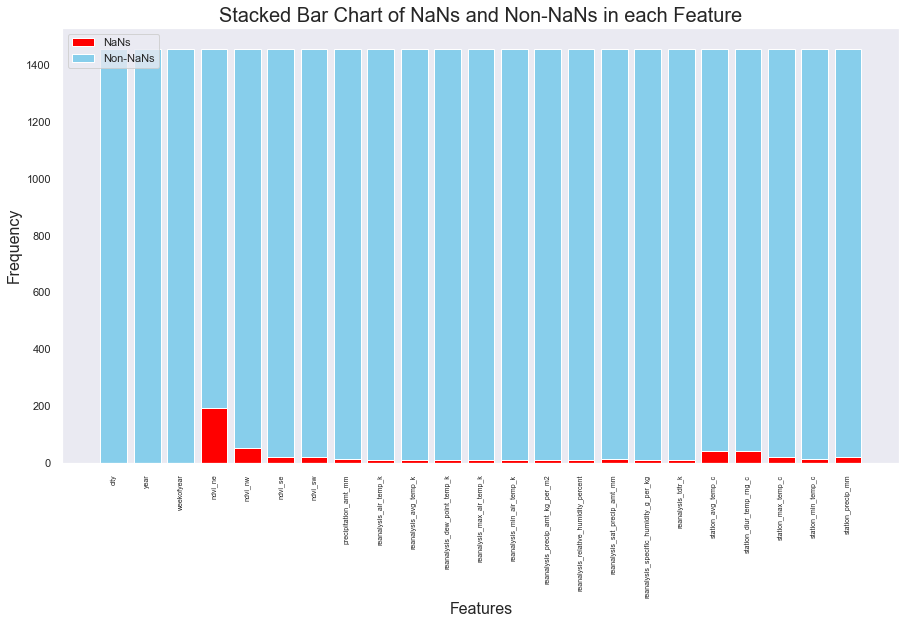

In [9]:
def feat_col_nans(df):
    '''
    FUNCTION: To display stacked bar chart of the NaNs vs Non-NaNs of each column in dataframe provided.
    
    Parameters
    ----------
    df: (pandas.DataFrame) Dataframe
    
    Returns
    -------
    Nothing. Displays the Stacked Bar chart
    '''
    # Get number of NaNs for each column
    nan_count_per_col = len(df) - df.count(axis=0)
    
    # Graph configs
    rcParams['figure.figsize'] = 15, 8
    sns.set()
    
    # Create NaNs
    plt.bar(np.arange(len(df.columns)), nan_count_per_col, color='red', edgecolor='white', label='NaNs')
    
    # Create Non-NaNs
    plt.bar(np.arange(len(df.columns)), df.count(), bottom=nan_count_per_col, color='skyblue', edgecolor='white', label='Non-NaNs')
    
    plt.title('Stacked Bar Chart of NaNs and Non-NaNs in each Feature', fontsize=20)
    plt.ylabel('Frequency', fontsize=16)
    plt.xlabel('Features', fontsize=16)
    plt.xticks(np.arange(len(df.columns)), df.columns, rotation=90, fontsize=7)
    plt.grid()
    plt.legend(loc='upper left');
    
feat_col_nans(raw_features_df)

__Seems like all the features don't have much missing data, so we don't have to remove any feature columns__

__Replace missing values with most frequent value__

In [10]:
# Which columns are the ones with NaN
raw_features_df.isna().any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_t

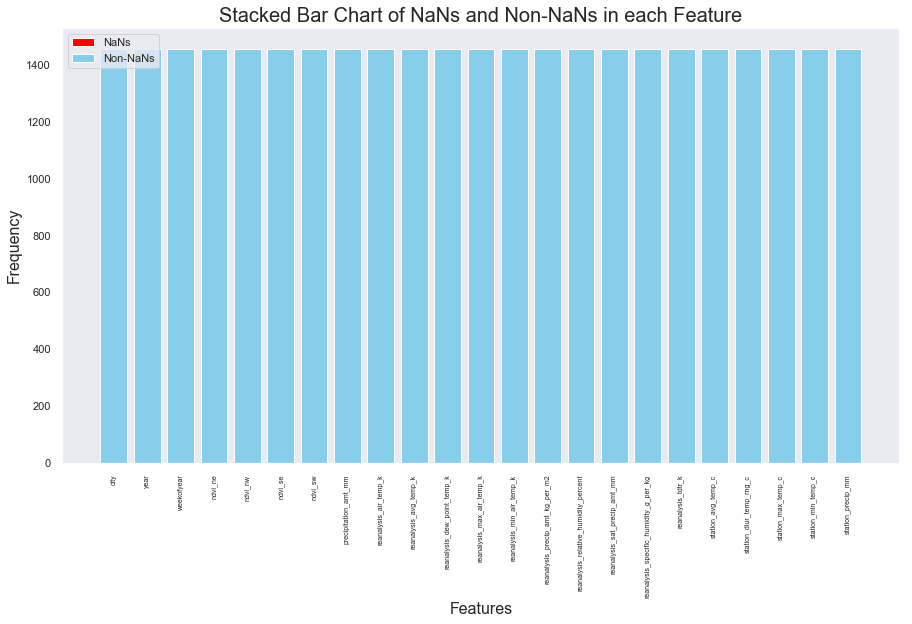

In [11]:
# Taking care of missing data
raw_features_df.fillna(raw_features_df.mode().iloc[0], inplace=True)
feat_col_nans(raw_features_df)

In [12]:
# Check the datatypes of the feature columns
raw_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1456 entries, 1990-04-30 to 2010-06-25
Data columns (total 23 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
ndvi_ne                                  1456 non-null float64
ndvi_nw                                  1456 non-null float64
ndvi_se                                  1456 non-null float64
ndvi_sw                                  1456 non-null float64
precipitation_amt_mm                     1456 non-null float64
reanalysis_air_temp_k                    1456 non-null float64
reanalysis_avg_temp_k                    1456 non-null float64
reanalysis_dew_point_temp_k              1456 non-null float64
reanalysis_max_air_temp_k                1456 non-null float64
reanalysis_min_air_temp_k                1456 non-null float64
reanalysis_precip_amt_kg_per_m2          1456 non-null float64
reanal

In [13]:
# The two cities in our dataset
raw_features_df['city'].unique()

array(['sj', 'iq'], dtype=object)

__Let's remove the time-related variables like `year` and `weekofyear` from the dataset and store the rest as our input variables for our model__

In [14]:
features_df = raw_features_df.drop(['year', 'weekofyear'], axis=1)

__Let's keep a dataframe for each city's data separately so that we are building 2 models for each machine learning technique we use, 1. Only City sj and 2. Only City iq__

In [15]:
# Let's split our data to one for city sj and one for city iq
sj_X = features_df[features_df['city'] == 'sj'].drop(['city'], axis=1)
sj_X.index = pd.to_datetime(sj_X.index)
sj_X.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,
1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [16]:
iq_X = features_df[features_df['city'] == 'iq'].drop(['city'], axis=1)
iq_X.index = pd.to_datetime(iq_X.index)
iq_X.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,
2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,291.1,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,292.6,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,291.5,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0


<a id="labels"></a>

---
## Labels

In [17]:
raw_labels_df = pd.read_csv('./data/dengai/labels/dengue_labels_train.csv')

In [18]:
raw_labels_df.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [19]:
# The total dengue cases for City sj
sj_y = raw_labels_df[raw_labels_df['city'] == 'sj']['total_cases']
sj_y.index = sj_X.index

# The total dengue cases for city iq
iq_y = raw_labels_df[raw_labels_df['city'] == 'iq']['total_cases']
iq_y.index = iq_X.index

In [20]:
sj_y.head()

week_start_date
1990-04-30    4
1990-05-07    5
1990-05-14    4
1990-05-21    3
1990-05-28    6
Name: total_cases, dtype: int64

In [21]:
iq_y.head()

week_start_date
2000-07-01    0
2000-07-08    0
2000-07-15    0
2000-07-22    0
2000-07-29    0
Name: total_cases, dtype: int64

### Visualize target distribution
__Let's first start to visualize the frequency of the dengue cases against the time__

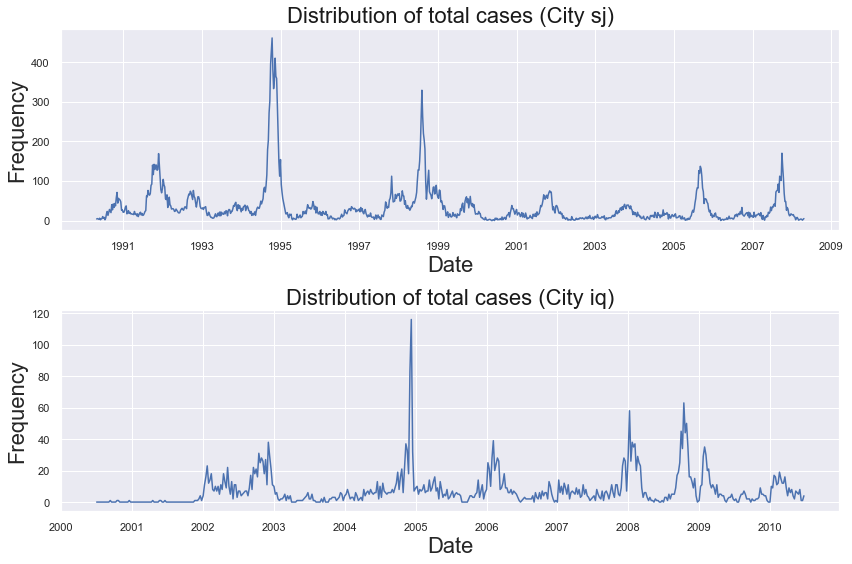

In [22]:
# Output Images Settings
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
fig, ax = plt.subplots(2,1)

ax[0].plot(sj_X.index, sj_y)
ax[0].grid(True)
ax[0].set_title("Distribution of total cases (City sj)", fontsize=22, color='k')
ax[0].set_ylabel("Frequency", fontsize=22)
ax[0].set_xlabel("Date", fontsize=22)

ax[1].plot(iq_X.index, iq_y)
ax[1].grid(True)
ax[1].set_title("Distribution of total cases (City iq)", fontsize=22, color='k')
ax[1].set_ylabel("Frequency", fontsize=22)
ax[1].set_xlabel("Date", fontsize=22)

plt.tight_layout()
plt.show();

__Seems like Dengue cases spiked in the second half of 1994, second half of 1998, second half of 2005, second half of 2007 for City sj and spiked in the second half of 2004, start of 2008, and second half of 2008 for City iq. However, there is some seasonal pattern to the data, which is logical given that dengue mosquitos breed more often in certain climates (hot and humid), so maybe a Seasonal Arima later on would reveal more information about the underlying trend.__

In [23]:
# Create a directory to store the cleaned data
mkdir('./data/dengai/cleaned')

# Save the X and y for each City
sj_X.to_csv(r'./data/dengai/cleaned/sj_X.csv')
sj_y.to_csv(r'./data/dengai/cleaned/sj_y.csv')
iq_X.to_csv(r'./data/dengai/cleaned/iq_X.csv')
iq_y.to_csv(r'./data/dengai/cleaned/iq_y.csv')

__In the next part of this project, we will work on building and training some naive regressors on this cleaned dataset__